# Preparação do ambiente

## Bibliotecas

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split


# from nltk import download
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# from sklearn.cluster import KMeans
# from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import precision_recall_curve, roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline

from joblib import load

from wordcloud import WordCloud

## Constantes e funções auxiliares

In [64]:
FILE_MARKETPLACES = '../datasets/label_issues/20240423/results/marketplaces.parquet'
FILE_SUPERVISAO_MERCADO = '../experimentos/assets/supervisao_mercado.xlsx'

FILE_CLF_20 = '../models/experimento_regulatron/exp_clf2_model.joblib'
FILE_CLF_30 = '../models/experimento_regulatron/exp_clf3_model.joblib'
FILE_CLF_31 = '../models/experimento_regulatron/exp_clf31_model.joblib'


In [56]:
MAP_MARKETPLACES = {
    'amazon': 'Amazon', 
    'magalu': 'Magazine Luiza', 
    'mercadolivre': 'Mercado Livre',
}

MAP_MARKETPLACES_MERCADO = {
    'Amazon': 'Amazon', 
    'Americanas': 'Lojas Americanas',
    'CasasBahia': 'Casas Bahia',
    'Magalu': 'Magazine Luiza', 
    'MercadoLivre': 'Mercado Livre'
}

MAP_PASSIVEL = {
    0: 'Não', 
    1: 'Sim', 
    2: 'Não é possível afirmar'
}

In [57]:
def clean_text(doc,stop_words=None):
   
    token_pattern = '(?u)\\b\\w\\w+\\b'
    tokens = re.findall(token_pattern, doc.lower())
    if stop_words is None:
        return ' '.join([word for word in tokens])
    else:
        return ' '.join([word for word in tokens if word not in stop_words])

In [58]:
def plot_models_benchmark(models, docs, targets, print_accuracy=True, ax=None):

    results = []
    # docs = df['titulo']
    # targets = df['passivel_homologacao']

    if print_accuracy:
        print('=' * 40)
        
    for model, name in models:
        
        acc = model.score(docs, targets)
        auc = roc_auc_score(targets,model.predict_proba(docs)[:,1])
        y_scores = model.decision_function(docs)
        fpr,tpr,auc_thresholds = roc_curve(targets,y_scores)
    
        model_results = {
            'name': name, 
            'acc': acc, 
            'auc': auc, 
            'fpr': fpr, 
            'tpr': tpr, 
            'auc_thresholds': auc_thresholds
        }
        
        results.append(model_results)
        
        if print_accuracy:
            print(name)
            print(f'Acurácia: {acc:.3f}')
            print('_' * 40)
            print()

    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(6,6))
        show_plot = True
    else:
        show_plot = False

    for result in results:

        name = result['name'] 
        auc = result['auc']
        fpr = result['fpr']
        tpr = result['tpr']
    
        ax.plot(fpr,tpr,label=f'{name}: {auc:.3f}')
        
    dummy = [0,1]
    ax.plot(dummy, dummy, linestyle='dashed', color='black', alpha=0.75, label='Classificador Aleatório')
    
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([0,0.5,1])
    
    # remove the frame of the chart
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_title('Curva ROC')
    ax.set_xlabel('Taxa de falsos positivos')
    ax.set_ylabel('Taxa de verdadeiros positivos')
    
    ax.legend(loc='lower right')

    if show_plot:
        plt.show()
        return results, fig
    else:
        return results
    

In [59]:
def plot_wordcloud(wc_docs,max_words=50,ax=None,title='Principais palavras'):

    if hasattr(wc_docs, '__iter__'):
        wc_docs = ' '.join(wc_docs)
   
    wc = WordCloud(max_words=max_words,height=300).generate(wc_docs)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
        show_plt = True
    else: 
        show_plt = False
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

    if show_plt:
        plt.show()

In [60]:
def prediction_type(ground_truth, predicted):
    if ground_truth == 0:
        if predicted == 0:
            return 'TN'
        if predicted == 1:
            return 'FP'
    elif ground_truth == 1:
        if predicted == 0:
            return 'FN'
        if predicted == 1:
            return 'TP'
    else:
        return '#'

In [61]:
df_marketplaces.passivel_homologacao.value_counts()

passivel_homologacao
1    9919
0    7475
2    1442
Name: count, dtype: int64

In [66]:
df_marketplaces.passivel_homologacao.value_counts()

passivel_homologacao
1    9982
0    7412
2    1442
Name: count, dtype: int64

# Carga e prepação dos dados

## Anúncios rotulados (base de treinamento e teste)

In [65]:
df_marketplaces = pd.read_parquet(FILE_MARKETPLACES)
map_groups = {(0,0):0, (1,0):1, (1,1):2}
df_marketplaces['grupo'] = df_marketplaces.apply(lambda row: (row['passivel_homologacao'],row['transmissor_rf']),axis=1).map(map_groups).fillna(3).astype(int)

df_marketplaces

,id,marketplace,titulo,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,grupo
0,125728,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick,2
1,125729,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones,2
2,125730,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook,2
3,125731,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
4,125732,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
...,...,...,...,...,...,...,...,...,...,...,...,...
18831,125715,amazon,CAIXA ACUSTICA PCX6500,,0,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
18832,125716,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),0
18833,125717,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
18834,125718,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2


## Anúncios de supervisão de mercado (base de validação)

In [67]:

dict_df_mercado = pd.read_excel(
    FILE_SUPERVISAO_MERCADO,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

df_list = []
for key in dict_df_mercado.keys():
    df = dict_df_mercado[key]
    df['marketplace'] = key
    df_list.append(df)
    
df_mercado = pd.concat(df_list)
df_mercado = df_mercado.dropna().reset_index(drop=True)
df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
df_mercado['marketplace'] = df_mercado['marketplace'].map(MAP_MARKETPLACES_MERCADO)

df_mercado

,texto_busca,titulo,passivel_homologacao,marketplace
0,Smartphone,Positivo Twist 4 Pro S518 Dual SIM 64 GB preto...,1,Mercado Livre
1,Smartphone,Xiaomi Pocophone Poco X6 Pro 5G Dual SIM 512 G...,1,Mercado Livre
2,Smartphone,"Smartphone Moto G22 Tela De 6,5 128 Gb 4 Ram P...",1,Mercado Livre
3,Smartphone,Smartphone Infinix Smart 6 64 Gb Dual Chip 2gb...,1,Mercado Livre
4,Smartphone,Smartphone Samsung Galaxy A21s Tela 6.5 64gb 4...,1,Mercado Livre
...,...,...,...,...
841,Bluetooth Wifi,fone bluetooth sem fio beatfade preto,1,Magazine Luiza
842,Bluetooth Wifi,Fone Bluetooth Sem Fio Wireless Compatível Com...,1,Magazine Luiza
843,Bluetooth Wifi,Fone Bluetooth Sem Fio Preto Caixinha Para Sam...,1,Magazine Luiza
844,Bluetooth Wifi,Fone De Ouvido Bluetooth Sem Fio Tipo Ambie De...,1,Magazine Luiza


## Preparação dos dados para treino, teste e validação

In [68]:
docs = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo']
labels = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao']
target_names = list(MAP_PASSIVEL.values())[:2]

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=724)

X_valid = df_mercado['titulo']
y_valid = df_mercado['passivel_homologacao']

X_valid_nao_rotulados = df_mercado[df_mercado['marketplace'].isin(['Lojas Americanas', 'Casas Bahia'])]['titulo']
y_valid_nao_rotulados = df_mercado[df_mercado['marketplace'].isin(['Lojas Americanas', 'Casas Bahia'])]['passivel_homologacao']

In [69]:
docs_test = pd.concat([X_test, X_valid])
targets_test = pd.concat([y_test, y_valid])

df_test_valid = pd.concat([docs_test, targets_test],axis=1)
df_test_valid = df_test_valid.drop_duplicates(subset='titulo').reset_index(drop=True)

stop_words = clf_31['vectorizer'].stop_words
df_test_valid['clean_titulo'] = df_test_valid['titulo'].apply(lambda doc: clean_text(doc,stop_words=stop_words))

X_test_valid = df_test_valid['titulo'].values
y_test_valid = df_test_valid['passivel_homologacao'].values

df_test_valid

,titulo,passivel_homologacao,clean_titulo
0,"Módulo de célula 18650, placa de proteção PCB,...",0,módulo célula 18650 placa proteção pcb confiáv...
1,"Controle remoto infravermelho Smart USB, emiss...",1,controle remoto infravermelho smart usb emisso...
2,Tomada Usb Veicular 4.2a Substitui O Acendedor...,0,tomada usb veicular 2a substitui acendedor vol...
3,"Receptor Transmissor HDMI Sem Fio, Kit Extenso...",1,receptor transmissor hdmi fio kit extensor exi...
4,"Ultimate Ears WONDERBOOM 3, Alto-falante Bluet...",1,ultimate ears wonderboom alto falante bluetoot...
...,...,...,...
5136,fone bluetooth sem fio beatfade preto,1,fone bluetooth fio beatfade preto
5137,Fone Bluetooth Sem Fio Wireless Compatível Com...,1,fone bluetooth fio wireless compatível samsung...
5138,Fone Bluetooth Sem Fio Preto Caixinha Para Sam...,1,fone bluetooth fio preto caixinha samsung a70 mdm
5139,Fone De Ouvido Bluetooth Sem Fio Tipo Ambie De...,1,fone ouvido bluetooth fio tipo ambie condução ...


# Análise

## Desempenho dos classificadores

### Cenário mais conservador

Neste cenário os dados utilizados são todos os anúncios analisados na fiscalização de supervisão de mercado

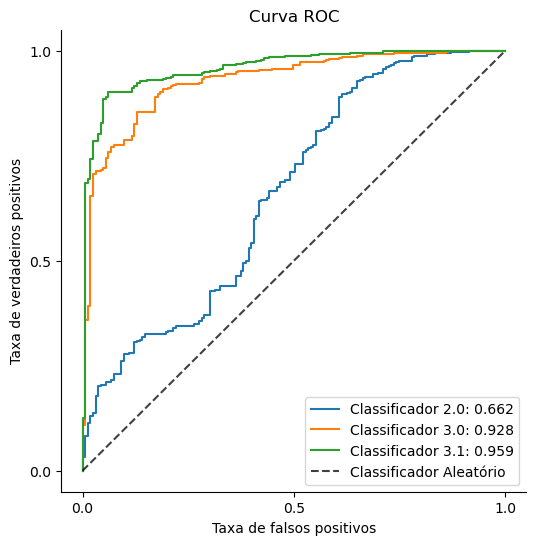

In [70]:
clf_20 = load(FILE_CLF_20)
clf_30 = load(FILE_CLF_30)
clf_31 = load(FILE_CLF_31)

models = [
    (clf_20, 'Classificador 2.0'),
    (clf_30, 'Classificador 3.0'),
    (clf_31, 'Classificador 3.1')    
]
    
results = plot_models_benchmark(models, X_valid, y_valid, print_accuracy=False)


### Cenário mais pessimista

Neste cenário os dados utilizados são os anúncios analisados na fiscalização de supervisão de mercado pesquisados nos marketplaces Casas Bahia e Lojas Americanas

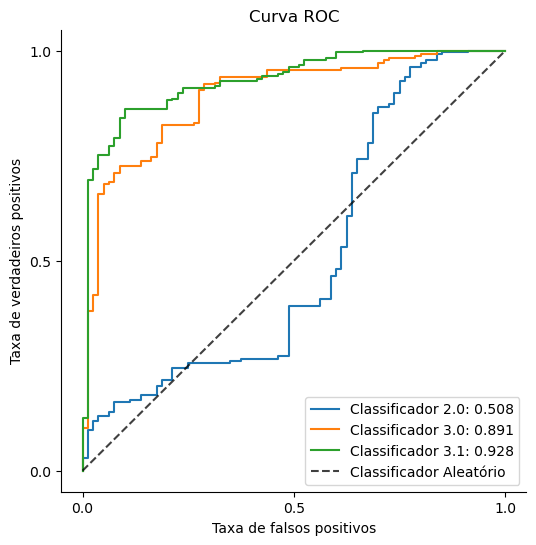

In [71]:

results = plot_models_benchmark(models, X_valid_nao_rotulados, y_valid_nao_rotulados, print_accuracy=False)

### Cenário mais otimista

Neste cenário os dados utilizados são os anúncios analisados na fiscalização de supervisão de mercado e o subconjunto de dados de teste do treinamento

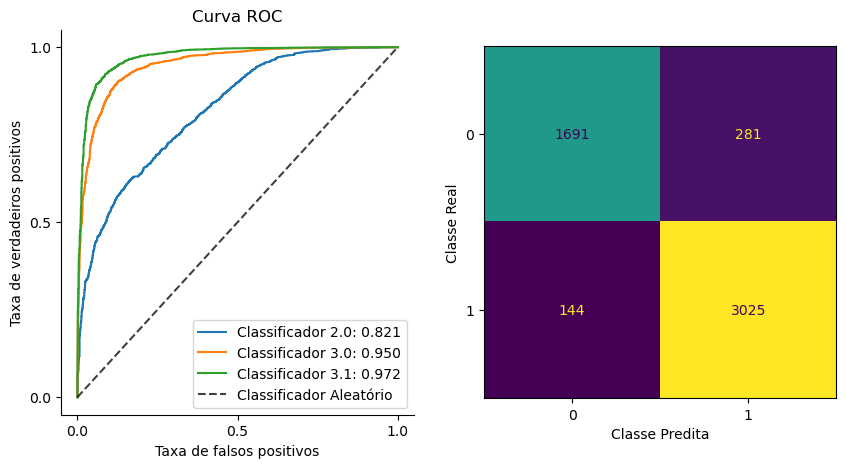

In [72]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

_=plot_models_benchmark(models, X_test_valid, y_test_valid, print_accuracy=False, ax=axs[0])
_=ConfusionMatrixDisplay.from_predictions(y_test_valid, clf_31.predict(X_test_valid), ax=axs[1], colorbar=False)
_=axs[1].set_xlabel('Classe Predita')
_=axs[1].set_ylabel('Classe Real')

## Predição de mercado

CPU times: total: 609 ms
Wall time: 745 ms


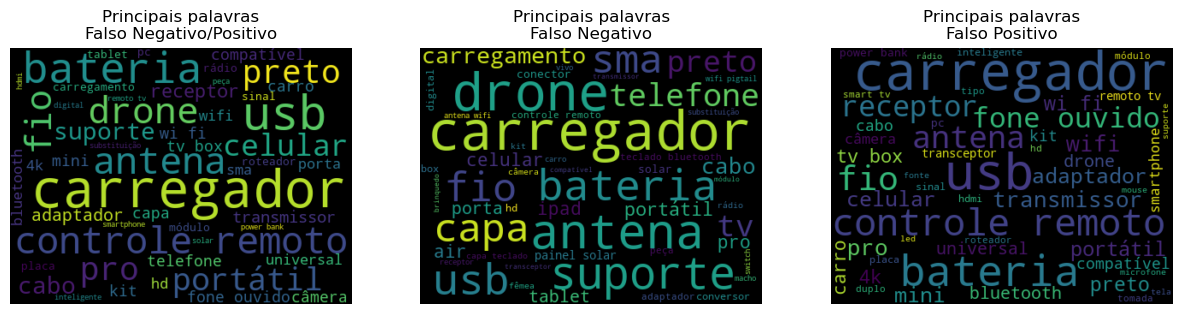

In [73]:
%%time
df_test_valid['predicao'] = clf_31.predict(df_test_valid['titulo'])
df_test_valid['resultado_predicao'] = df_test_valid.apply(lambda row: prediction_type(row['passivel_homologacao'], row['predicao']),axis=1)

clean_docs = df_test_valid[df_test_valid['resultado_predicao'].isin(['FN','FP'])]['clean_titulo']
fn_clean_docs = df_test_valid[df_test_valid['resultado_predicao']=='FN']['clean_titulo']
fp_clean_docs = df_test_valid[df_test_valid['resultado_predicao']=='FP']['clean_titulo']

fig, axs = plt.subplots(1,3,figsize=(15,5))
plot_wordcloud(clean_docs,ax=axs[0], title='Principais palavras\nFalso Negativo/Positivo')
plot_wordcloud(fn_clean_docs,ax=axs[1], title='Principais palavras\nFalso Negativo')
plot_wordcloud(fp_clean_docs,ax=axs[2], title='Principais palavras\nFalso Positivo')

Investigar bluetooth em falos positivos, me parece erro de rotulagem

In [74]:
df_test_valid[(df_test_valid['clean_titulo'].str.contains('bluetooth'))&(df_test_valid['resultado_predicao']=='FP')]

,titulo,passivel_homologacao,clean_titulo,predicao,resultado_predicao
517,Para A Caneta Samsung Stylus S S6Lite S7FE S7 ...,0,caneta samsung stylus s6lite s7fe s7 s7plus s8...,1,FP
1003,SHOKZ Fone de ouvido MP3 com condução óssea MP...,0,shokz fone ouvido mp3 condução óssea mp3 prova...,1,FP
1018,FTRONGRT Capa de Fone de Ouvido Bluetooth para...,0,ftrongrt capa fone ouvido bluetooth qcy arcbud...,1,FP
1235,Adaptador de placa de rede Bewinner M.2 NGFF p...,0,adaptador placa rede bewinner ngff mini pci wi...,1,FP
2643,Carregador 5v 2a Usb Fonte Tomada Smartwatch F...,0,carregador 5v 2a usb fonte tomada smartwatch f...,1,FP
2658,"Headphone Charging Case, Accessories, Computer...",0,headphone charging case accessories computer c...,1,FP
2672,Substituição da caneta Stylus para Samsung Gal...,0,substituição caneta stylus samsung galaxy note...,1,FP
2765,"Almofadas de ouvido para fones de ouvido, fone...",0,almofadas ouvido fones ouvido fones ouvido fio...,1,FP
2994,Cabo Conexão Wi-fi Bluetooth X Ir Tv LG 32lj60...,0,cabo conexão wi fi bluetooth ir tv lg 32lj600b...,1,FP
3832,Suporte Articulado com 3 movimentos para Smart...,0,suporte articulado movimentos smart tv 4k 50 p...,1,FP


0        streaming box s tucson 2018 a 2022 carplay 4g ...
1        smartphone motorola moto g52 xt2221-1 dual sim...
2        notebook dell latitude 7490 i5 8ª ger ddr4 16g...
3        mini rede sem fio, placa de rede sem fio usb 3...
4        fone bluetooth tws kaidi kd-771 - 5.1, touch, ...
                               ...                        
18831                               caixa acustica pcx6500
18832    conector de cauda de celular 10 pcs carregando...
18833    avantree medley clear - fones de ouvido sem fi...
18834    hilitand adaptador sem fio, placa de rede sem ...
18835    drone vectron quadricoptero tamanho g - polibrinq
Name: titulo, Length: 18836, dtype: string

In [53]:
FILE_SAMPLES = '../datasets/label_issues/20240423/results/samples.parquet'
FILE_ITEMS = '../datasets/label_issues/20240423/results/items.parquet'
df_items = pd.read_parquet(FILE_ITEMS)
df_items['titulo_lower'] = df_items['titulo'].str.lower()

df_items[(df_items['titulo_lower'].str.contains('bluetooth'))&(df_items['passivel_homologacao']==0)]

,id,marketplace,titulo,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,titulo_lower
245,125973,amazon,Adaptador de placa de rede Bewinner M.2 NGFF p...,Características: Ver itens relacionados,1,1,2,2,0,0,Peça ou acessório com fio para computador,adaptador de placa de rede bewinner m.2 ngff p...
1035,126763,amazon,Capa protetora de alto-falante à prova de choq...,,1,1,2,2,0,0,Outro tipo/categoria (não listada acima),capa protetora de alto-falante à prova de choq...
1480,127208,amazon,Capa de couro universal com teclado para table...,,0,1,2,2,0,0,Outro tipo/categoria (não listada acima),capa de couro universal com teclado para table...
2659,127875,amazon,Sanpyl Bolsa de armazenamento preta - Shock Tr...,,1,1,2,2,0,0,Não é possível afirmar,sanpyl bolsa de armazenamento preta - shock tr...
2662,127878,amazon,Aeihevo Bolsa de transporte Harman Kardon Onyx...,,1,1,2,2,0,0,Não é possível afirmar,aeihevo bolsa de transporte harman kardon onyx...
...,...,...,...,...,...,...,...,...,...,...,...,...
18125,146016,amazon,"Estojo Rígido EVA para JBL Go 3, Alto-falante ...","CAIXA DE EVA RÍGIDA: Para GO3, a caixa rígida...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),"estojo rígido eva para jbl go 3, alto-falante ..."
18453,146344,amazon,Enfudid Kit de limpeza de eletrônicos 7 em 1 –...,,1,1,2,2,0,0,Outro tipo/categoria (não listada acima),enfudid kit de limpeza de eletrônicos 7 em 1 –...
18540,146431,amazon,Capa com teclado para iPad Air 5ª geração 2022...,,1,1,2,2,0,0,Outro tipo/categoria (não listada acima),capa com teclado para ipad air 5ª geração 2022...
18773,146664,mercadolivre,Placa Usb /sd/ Card/bluetooth Lenoxx Ca-6000 O...,- ATENÇÃO: TODO PRODUTO POSSUI UMA ETIQUETA DE...,0,1,0,1,0,0,Outro tipo/categoria (não listada acima),placa usb /sd/ card/bluetooth lenoxx ca-6000 o...


In [24]:
df_test_valid

,titulo,passivel_homologacao,predicao,resultado_predicao
0,"Módulo de célula 18650, placa de proteção PCB,...",0,0,TN
1,"Controle remoto infravermelho Smart USB, emiss...",1,1,TP
2,Tomada Usb Veicular 4.2a Substitui O Acendedor...,0,1,FP
3,"Receptor Transmissor HDMI Sem Fio, Kit Extenso...",1,1,TP
4,"Ultimate Ears WONDERBOOM 3, Alto-falante Bluet...",1,1,TP
...,...,...,...,...
5136,fone bluetooth sem fio beatfade preto,1,1,TP
5137,Fone Bluetooth Sem Fio Wireless Compatível Com...,1,1,TP
5138,Fone Bluetooth Sem Fio Preto Caixinha Para Sam...,1,1,TP
5139,Fone De Ouvido Bluetooth Sem Fio Tipo Ambie De...,1,1,TP
